In [1]:
import pandas as pd
import numpy as np
import glob
import PIL
from PIL import Image
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

In [2]:
path = r'D:\Semester 2\Data Analytics and Visualisation\Assignment 2\Dataset\*' #The path of the dataset with the 8 directories
def dict_df(path : str, size = 250):
    d = {} #A dictionary in which we will pass a list of the image converted to array and the target. The key will be a number from 0 to 7999 in ascending order
    count = 0 #A counter for the key of the dictionary
    for i in glob.glob(path): #For i in the path, the glob function will return a list with paths for each dictionay that the images are found in
        for j in glob.glob(i + "/*.jpg"): #For j in the list that the glob function returns. The list will contain the files in the dictionary with path i that have an extension jpg
            im = Image.open(j) #We open each image
            im = im.resize((size,size)) #We resize it
            arr = np.asarray(im) #We convert it to an array
            d[count] = [arr, i.split("\\")[-1]] #We pass a list into the dictionary. The will contain the image (converted to an array) and the target. The target has been got by splitting the path using \\ and we get the last element of the list which is the label of each image
            count += 1 #We add 1 to the counter to move to the second observation and pass it with different key into the dictionary
    return d
d = dict_df(path)

In [3]:
df = pd.DataFrame.from_dict(d, orient = "index", columns = ['Image', "Target"]) #We create a dataframe from the dictionary above
np.random.seed(209268) #We set a seed
df = df.sample(frac = 1).reset_index(drop = True) #And we shuffle the dataset reseting the index. This function will create a new collumn with the indeces before shuffling, we set the argument drop equals to true to discard this column

In [4]:
from sklearn.model_selection import train_test_split #We import the function to split the dataset into training validation and test
np.random.seed(268) #We set a seed with the last 3 digits of the student number
train, val_test = train_test_split(df, train_size = 0.70) #We split the training set into training and validation_test set holding 70% of the observation for the training set
validation, test = train_test_split(val_test, train_size = 0.5) #And we split the validation_test set into validation and test set. 30% of the observations of the whole dataset consists the validation_test set. By splitting it using 50% the final splitting will be 70:15:15 for the training validation and test set respectively
train = train.reset_index(drop = True) #70% #We reset the index for the training 
validation = validation.reset_index(drop = True) #15% #We reset the index for the validation
test = test.reset_index(drop = True) #15% #We reset the index for the test

In [5]:
#Fixing the datasets converting them to arrays with dimension (#ofobservations, 250, 250, 3) 250x250x3 is the dimension of each image since 250 pixels vertically, 250 pixels horizontally, 3 for RGB
def from_df_2_array(df_column):
    rows, col, rgb = df_column[0].shape
    arr = np.concatenate(df_column).reshape((len(df_column),rows,col,rgb))
    return arr

training_array = from_df_2_array(train['Image'])
validation_array = from_df_2_array(validation['Image'])
test_array = from_df_2_array(test['Image'])

In [6]:
#Since we have 8 classes, we will use softmax and we fix the Y variable accordingly.
enc = OrdinalEncoder()
Y_train = enc.fit_transform(train[['Target']])
Y_validation = enc.fit_transform(validation[['Target']])
Y_test = enc.fit_transform(test[['Target']])
# 0 -> dyed-lifted-polyps
# 1 -> dyed-resection-margins
# 2 -> esophagitis
# 3 -> normal-cecum
# 4 -> normal-pylorus
# 5 -> normal-z-line
# 6 -> polyps
# 7 -> ulcerative-colitis
y_train = to_categorical(Y_train)
y_validation = to_categorical(Y_validation)
y_test = to_categorical(Y_test)
#Data set read to pass it into the C-NN

In [7]:
#Normalization of the arrays 
x_train = training_array.astype("float32")/255.0
x_validation = validation_array.astype("float32")/255.0
x_test = test_array.astype("float32")/255.0

In [18]:
#CNN Baseline
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_uniform',input_shape=(250,250,3),data_format = 'channels_last',strides = (2,2)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(8,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 124, 124, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 124, 124, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 123008)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               15745152  
                                                                 
 dropout_2 (Dropout)         (None, 128)              

In [10]:
filepath = r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\model"
cb = keras.callbacks.ModelCheckpoint(filepath, #filepath to save the model 
                                   monitor = "val_accuracy", #best val_accuracy will show which is the best model
                                   save_best_only = True)
history = model.fit(x_train, y_train ,epochs = 100, validation_data = (x_validation, y_validation), callbacks = [cb]) #We fit the dataset to train the model

Epoch 1/100
175/175 [==============================] - 73s 401ms/step - loss: 4.0465 - accuracy: 0.4479 - val_loss: 1.6354 - val_accuracy: 0.5042
Epoch 2/100
175/175 [==============================] - 61s 349ms/step - loss: 1.1948 - accuracy: 0.5241 - val_loss: 1.0040 - val_accuracy: 0.5842
Epoch 3/100
175/175 [==============================] - 60s 340ms/step - loss: 1.0688 - accuracy: 0.5677 - val_loss: 1.0312 - val_accuracy: 0.6067
Epoch 4/100
175/175 [==============================] - 63s 358ms/step - loss: 1.0301 - accuracy: 0.5793 - val_loss: 1.0235 - val_accuracy: 0.6325
Epoch 5/100
175/175 [==============================] - 67s 384ms/step - loss: 0.9986 - accuracy: 0.5639 - val_loss: 0.8422 - val_accuracy: 0.6700
Epoch 6/100
175/175 [==============================] - 61s 350ms/step - loss: 0.9343 - accuracy: 0.5871 - val_loss: 1.0043 - val_accuracy: 0.6450
Epoch 7/100
175/175 [==============================] - 61s 347ms/step - loss: 0.9188 - accuracy: 0.6148 - val_loss: 0.9640 -

Epoch 44/100
175/175 [==============================] - 63s 361ms/step - loss: 0.3565 - accuracy: 0.8521 - val_loss: 1.0968 - val_accuracy: 0.7217
Epoch 45/100
175/175 [==============================] - 62s 352ms/step - loss: 0.3616 - accuracy: 0.8623 - val_loss: 1.1280 - val_accuracy: 0.7242
Epoch 46/100
175/175 [==============================] - 64s 364ms/step - loss: 0.2989 - accuracy: 0.8771 - val_loss: 1.2994 - val_accuracy: 0.7133
Epoch 47/100
175/175 [==============================] - 64s 365ms/step - loss: 0.2882 - accuracy: 0.8821 - val_loss: 1.3540 - val_accuracy: 0.7408
Epoch 48/100
175/175 [==============================] - 64s 366ms/step - loss: 0.3221 - accuracy: 0.8734 - val_loss: 1.1299 - val_accuracy: 0.7292
Epoch 49/100
175/175 [==============================] - 65s 369ms/step - loss: 0.3045 - accuracy: 0.8777 - val_loss: 1.5512 - val_accuracy: 0.6792
Epoch 50/100
175/175 [==============================] - 63s 358ms/step - loss: 0.3365 - accuracy: 0.8629 - val_loss: 1

Epoch 100/100
175/175 [==============================] - 65s 370ms/step - loss: 0.1837 - accuracy: 0.9262 - val_loss: 2.3109 - val_accuracy: 0.7108


In [11]:
baseline = keras.models.load_model(r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\model") #We load the best model

In [13]:
baseline.evaluate(x_test,y_test) #We evaluate the test set

38/38 [==============================] - 4s 83ms/step - loss: 0.9089 - accuracy: 0.7342


[0.9088663458824158, 0.73416668176651]

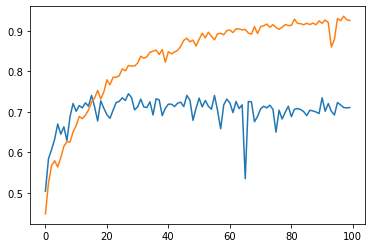

In [20]:
plt.plot(list(range(100)),history.history['val_accuracy'])
plt.plot(list(range(100)),history.history['accuracy'])
plt.show()

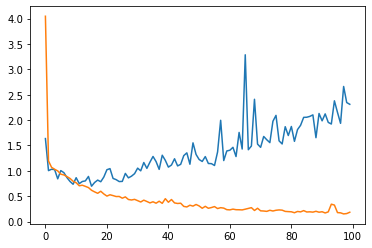

In [22]:
plt.plot(list(range(100)),history.history['val_loss'])
plt.plot(list(range(100)),history.history['loss'])
plt.show()

In [61]:
#a better model
model1 = models.Sequential()
model1.add(layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_uniform',input_shape=(250,250,3),data_format = 'channels_last',strides = (2,2)))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D((2,2)))

model1.add(layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_uniform',data_format = 'channels_last',strides = (2,2)))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D((2,2)))

model1.add(layers.Flatten())
model1.add(layers.Dense(512,activation='relu'))
model1.add(layers.Dropout(0.3))

model1.add(layers.Dense(256,activation='relu'))

model1.add(layers.Dense(8,activation='softmax'))

model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
filepath = r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\model1" #Same logic for the second model
cb1 = keras.callbacks.ModelCheckpoint(filepath,
                                   monitor = "val_loss",
                                   save_best_only = True)
history = model1.fit(x_train, y_train ,epochs = 50, validation_data = (x_validation, y_validation), callbacks = [cb1])

Epoch 1/50
175/175 [==============================] - 124s 699ms/step - loss: 1.9989 - accuracy: 0.5582 - val_loss: 1.4580 - val_accuracy: 0.5075
Epoch 2/50
175/175 [==============================] - 108s 619ms/step - loss: 0.8996 - accuracy: 0.6388 - val_loss: 0.8569 - val_accuracy: 0.6508
Epoch 3/50
175/175 [==============================] - 110s 627ms/step - loss: 0.8056 - accuracy: 0.6584 - val_loss: 0.7484 - val_accuracy: 0.6833
Epoch 4/50
175/175 [==============================] - 121s 690ms/step - loss: 0.7038 - accuracy: 0.6886 - val_loss: 0.6443 - val_accuracy: 0.7075
Epoch 5/50
175/175 [==============================] - 120s 689ms/step - loss: 0.6947 - accuracy: 0.6954 - val_loss: 0.7336 - val_accuracy: 0.6925
Epoch 6/50
175/175 [==============================] - 122s 697ms/step - loss: 0.6617 - accuracy: 0.7113 - val_loss: 0.7639 - val_accuracy: 0.6733
Epoch 7/50
175/175 [==============================] - 123s 702ms/step - loss: 0.5931 - accuracy: 0.7307 - val_loss: 0.5993 -

Epoch 49/50
175/175 [==============================] - 124s 711ms/step - loss: 0.0656 - accuracy: 0.9821 - val_loss: 1.3818 - val_accuracy: 0.7517
Epoch 50/50
175/175 [==============================] - 124s 708ms/step - loss: 0.0580 - accuracy: 0.9807 - val_loss: 1.6181 - val_accuracy: 0.7292


In [13]:
better_model = keras.models.load_model(r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\model1")
better_model.evaluate(x_test,y_test)

38/38 [==============================] - 6s 147ms/step - loss: 0.6660 - accuracy: 0.7400


[0.665986955165863, 0.7400000095367432]

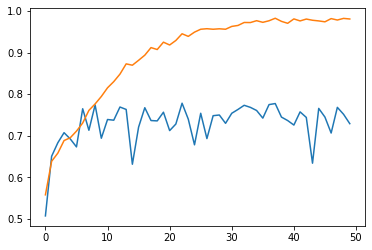

In [15]:
plt.plot(list(range(50)),history.history['val_accuracy'])
plt.plot(list(range(50)),history.history['accuracy'])
plt.show()

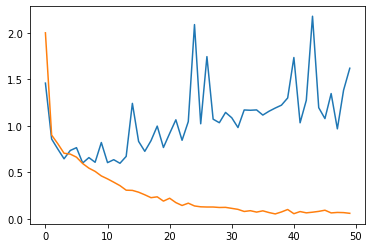

In [16]:
plt.plot(list(range(50)),history.history['val_loss'])
plt.plot(list(range(50)),history.history['loss'])
plt.show()

In [8]:
#Mix up
BATCH_SIZE = 64
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf.data.Dataset.from_tensor_slices((x_validation, y_validation)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [9]:
def sample_beta_distribution(size, concentration_0=2, concentration_1=0.5): #beta distribution
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2): #Mix up to merge two images
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

[0.10129927098751068, 0.0, 0.0, 0.8987007141113281, 0.0, 0.0, 0.0, 0.0]
[0.03745034709572792, 0.96254962682724, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.9999999403953552, 0.0, 0.0, 5.960464477539063e-08]
[0.0, 0.05933796986937523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9406620264053345]
[0.0, 0.0, 0.0, 0.0003628067788667977, 0.9996371865272522, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 5.525350570678711e-05, 0.0, 0.9999447464942932, 0.0, 0.0, 0.0]
[0.0, 0.2256382554769516, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7743617296218872]


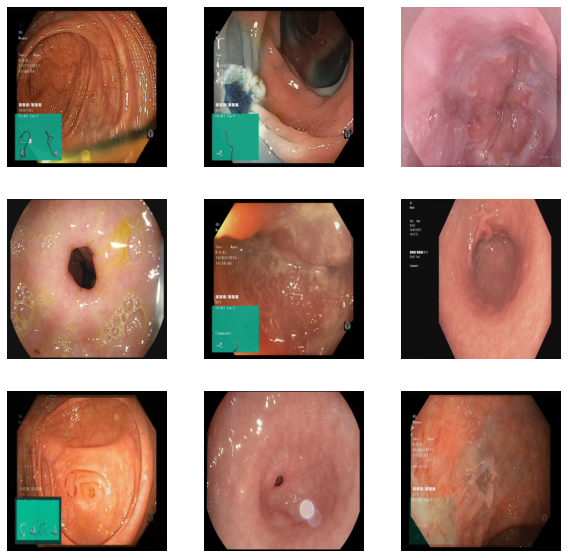

In [27]:
AUTO = tf.data.AUTOTUNE #Constructing the dataset and ploting some images from the dataset
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
)

# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

In [14]:
#We train the last model with the new dataset
filepath = r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\mixup"
cb1 = keras.callbacks.ModelCheckpoint(filepath,
                                   monitor = "val_loss",
                                   save_best_only = True)
history1 = model1.fit(train_ds_mu,epochs = 50, validation_data = val_ds, callbacks = [cb1])

Epoch 1/50
88/88 [==============================] - 150s 1s/step - loss: 2.1880 - accuracy: 0.5414 - val_loss: 1.5219 - val_accuracy: 0.4375
Epoch 2/50
88/88 [==============================] - 157s 1s/step - loss: 1.1398 - accuracy: 0.6132 - val_loss: 1.2274 - val_accuracy: 0.5608
Epoch 3/50
88/88 [==============================] - 157s 1s/step - loss: 1.0666 - accuracy: 0.6357 - val_loss: 0.9091 - val_accuracy: 0.6858
Epoch 4/50
88/88 [==============================] - 157s 1s/step - loss: 0.9870 - accuracy: 0.6607 - val_loss: 0.8065 - val_accuracy: 0.6875
Epoch 5/50
88/88 [==============================] - 157s 1s/step - loss: 0.9537 - accuracy: 0.6805 - val_loss: 0.7890 - val_accuracy: 0.6892
Epoch 6/50
88/88 [==============================] - 156s 1s/step - loss: 0.9369 - accuracy: 0.6818 - val_loss: 0.6511 - val_accuracy: 0.7358
Epoch 7/50
88/88 [==============================] - 157s 1s/step - loss: 0.9214 - accuracy: 0.6961 - val_loss: 0.6417 - val_accuracy: 0.7483
Epoch 8/50
88

In [16]:
mix_up_model = keras.models.load_model(r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\mixup")
mix_up_model.evaluate(x_test,y_test)

38/38 [==============================] - 6s 149ms/step - loss: 0.6301 - accuracy: 0.7508


[0.6300723552703857, 0.7508333325386047]

In [29]:
plt.plot(list(range(50)),history1.history['val_accuracy'])
plt.plot(list(range(50)),history1.history['accuracy'])
plt.show()

NameError: name 'history1' is not defined

In [ ]:
plt.plot(list(range(50)),history1.history['val_loss'])
plt.plot(list(range(50)),history1.history['loss'])
plt.show()

In [56]:
#Cut mix
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

In [57]:
#constructing the dataset
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)

train_ds_simple = tf.data.Dataset.from_tensor_slices((x_train, y_train))

val_ds = tf.data.Dataset.from_tensor_slices((x_validation, y_validation))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds_simple = (
    train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Combine two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

test_ds = (
    test_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = (
    val_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [58]:
@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

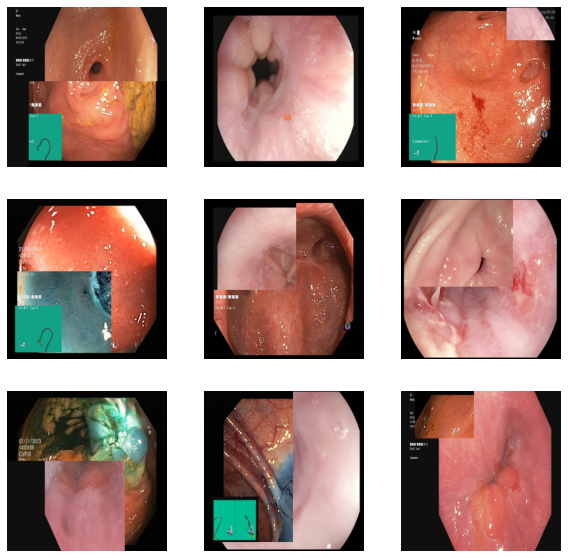

In [59]:
#We fix the training set and plot some images of the new dataset
AUTO = tf.data.AUTOTUNE
IMG_SIZE = 250
BATCH_SIZE = 32
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")


In [62]:
filepath = r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\cutmix"
cb1 = keras.callbacks.ModelCheckpoint(filepath,
                                   monitor = "val_loss",
                                   save_best_only = True)
history2 = model1.fit(train_ds_cmu,epochs = 50,validation_data = val_ds, callbacks = [cb1])

Epoch 1/50
175/175 [==============================] - 197s 1s/step - loss: 2.0315 - accuracy: 0.4457 - val_loss: 4.0450 - val_accuracy: 0.1917
Epoch 2/50
175/175 [==============================] - 205s 1s/step - loss: 1.3769 - accuracy: 0.5296 - val_loss: 0.9351 - val_accuracy: 0.6233
Epoch 3/50
175/175 [==============================] - 205s 1s/step - loss: 1.3195 - accuracy: 0.5448 - val_loss: 0.8711 - val_accuracy: 0.6117
Epoch 4/50
175/175 [==============================] - 199s 1s/step - loss: 1.2445 - accuracy: 0.5786 - val_loss: 0.7079 - val_accuracy: 0.6883
Epoch 5/50
175/175 [==============================] - 195s 1s/step - loss: 1.2139 - accuracy: 0.5909 - val_loss: 0.6990 - val_accuracy: 0.7058
Epoch 6/50
175/175 [==============================] - 195s 1s/step - loss: 1.1742 - accuracy: 0.5962 - val_loss: 0.6804 - val_accuracy: 0.7150
Epoch 7/50
175/175 [==============================] - 196s 1s/step - loss: 1.1693 - accuracy: 0.6071 - val_loss: 0.7533 - val_accuracy: 0.6883

In [63]:
cutmix = keras.models.load_model(r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\cutmix")
cutmix.evaluate(x_test,y_test)

38/38 [==============================] - 7s 184ms/step - loss: 0.5718 - accuracy: 0.7633


[0.5717816948890686, 0.7633333206176758]

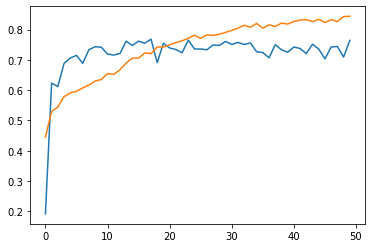

In [65]:
plt.plot(list(range(50)),history2.history['val_accuracy'])
plt.plot(list(range(50)),history2.history['accuracy'])
plt.show()

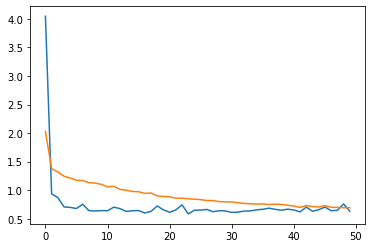

In [66]:
plt.plot(list(range(50)),history2.history['val_loss'])
plt.plot(list(range(50)),history2.history['loss'])
plt.show()


In [368]:
#Q3
def array(containt): #Function to return a containt of a file as an flatten array
    al = containt.split("\n")[:-1] #Split by line. the last element is empty that s the reason of [:-1]
    column = [] #empty column to append the numbers as array
    for i in al: #For i in al which is a list of strings, each string has the name of the GF : numbers for each GF
        names = i.split(":") #We split it by : 
        column.append(np.asarray(names[1].split(","))) #We take the [1]=second element which is the numbers for each GF and we split it by comma. it is a list and convert it to array, the result is passed into the empty list initialized above
    arrr = np.asarray(column) #we convert it to array
    aaa = np.concatenate(arrr).astype("float32") #and concatenate converting it from str to float
    return(aaa) #we return the flatten array. It is the containt of one file only

path3 = r"D:\Semester 2\Data Analytics and Visualisation\Assignment 2\Features" #The path
subfolders = glob.glob(path3 + "/*") #We get a list with the subfolders
d = {} #An empty dictionary. at the very end this dictionary will be {0:[array with the containt of the first file, label of the first file], 1:same for the second file,...,7999:same for the last file}
count = 0 #A counter which will be the key of the dictionary discribed at the line above
for i in subfolders: #a for loop in a list with the paths of subfolders
    files = glob.glob(i + "/*.features") #We add to the path the extension of the files we want to look for. It will be a list with the path of each file in each subfolder
    for j in files: #a for loop in the list files with paths of all the files 
        f = open(j, 'r') #We open the file with mode = read
        containt = f.read() #We read the containt
        d[count] = [array(containt), i.split("\\")[-1]] #We pass into the dictionary the flatten array taken from the function array and the label which is the last element of the path i split by \\
        count += 1 #We add 1 to the count to pass into the dictionary the next file's containt
        f.close() #we close the file
    

C:\Users\jimbi\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [374]:
df_feature = pd.DataFrame.from_dict(d, orient='index', columns = ['X', 'Y']) #We create a dataframe from the dictionary above. orient index since the keys will be the index of the dataframe, and columns X,Y because the first element of the list is the the independent variables and the second element is the lebel = dependent variable
np.random.seed(9268) #We set a seed to get the same results
df_feature = df_feature.sample(frac = 1).reset_index(drop = True) #we shuffle it reseting the index and drop the new column with the previous index

In [406]:
df_feature

,X,Y
0,"[0.0, 1.0, 5.5, 0.0, 0.0, 0.0, 2.5, 2.5, 3.0, ...",dyed-resection-margins
1,"[0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 2.5, 5.5, 4.0, ...",normal-cecum
2,"[2.0, 0.0, 5.0, 0.0, 0.0, 0.0, 2.0, 4.5, 2.0, ...",normal-cecum
3,"[0.5, 4.0, 5.0, 0.0, 0.0, 0.0, 1.5, 1.5, 4.0, ...",dyed-resection-margins
4,"[1.0, 1.5, 5.0, 0.0, 0.0, 0.0, 2.0, 3.0, 3.0, ...",dyed-resection-margins
...,...,...
7995,"[3.5, 2.0, 2.0, 7.0, 2.0, 3.0, 0.0, 0.0, 0.0, ...",normal-z-line
7996,"[2.5, 2.0, 2.0, 4.0, 0.5, 1.0, 6.5, 2.0, 1.5, ...",normal-pylorus
7997,"[0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 3.5, 4.5, 6.5, ...",ulcerative-colitis
7998,"[0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 3.5, 6.0, 1.5, ...",normal-cecum


In [93]:
df_feat = np.concatenate(df_feature["X"]) #We concatenate all the arrays in variable X to get an array with all the observations
y_feat = np.asarray(df_feature["Y"]) #We create an array with the labels

In [94]:
dt = df_feat.reshape((8000,1185)) #We reshape the concatenated array to 8000 (observations), 1185(independent variables)

In [95]:
Ar = np.unique(y_feat) #We get the unique values of the label
counter = 0 #We initialize a counter to replace each value of the Y with a number from 0 to 7
#0 -> dyed-lifted-polyps
#1 -> dyed-resection-margins
#2 -> esophagitis
#3 -> normal-cecum
#4 -> normal-pylorus
#5 -> normal-z-line
#6 -> polyps
#7 -> ulcerative-colitis
for i in Ar: #For i in unique values -> unique values are strings with the name of the class
    y_feat[y_feat == i] = counter #When the array is equal to the first name we pass zero to all these elements, second name ->1, third name ->2 and so forth
    counter += 1 #We add one to the counter

In [199]:
from sklearn.model_selection import train_test_split
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(dt, y_feat, test_size = 0.5) #We split the dataset into train and test 50% since the paper uses 500 observations for each class

In [340]:
from sklearn.ensemble import RandomForestClassifier #We import the Random Forest
RF = RandomForestClassifier(n_estimators = 200, max_depth = 40, max_features = 15, min_samples_leaf = 10,
                            min_samples_split = 20, criterion = 'entropy', max_leaf_nodes = 500) #We set the hyperparameters playing around with the values we got with the best hyperparameter grid
#GF6 = RF.fit(X_TRAIN, Y_TRAIN.astype("int"))

In [341]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RF, X_TRAIN, Y_TRAIN.astype("int"), cv = 2) #We run two fold cross validation to check the accuracy

In [342]:
scores

array([0.7285, 0.7345])

In [347]:
#We initially tune it using the grid shown below and we get the best values
from sklearn.model_selection import GridSearchCV #11.5 minutes
import timeit
param_Grid = {"n_estimators" : [100,150,200,250,300,350,400,500],
             "max_depth" : [10,20,50,100,200,400,600,800]#,
              #"max_features" : [5,10,20,30,40,50,60,70],
              #"criterion" : ['entropy', 'gini'],
              #"max_leaf_nodes" : [None,50,100,200,300,400]
             }
start = timeit.default_timer()
GSCV = GridSearchCV(estimator = RandomForestClassifier(),param_grid = param_Grid, cv = 2)
tuning = GSCV.fit(X_TRAIN, Y_TRAIN.astype("int"))
stop = timeit.default_timer()
print('Time: ', (stop - start)/60)

Time:  11.550617369999964


In [348]:
GSCV.best_score_

0.751

In [354]:
GSCV.best_params_

{'max_depth': 400, 'n_estimators': 500}

In [355]:
GSCV.cv_results_

{'mean_fit_time': array([1.41446888, 2.4080056 , 2.91937506, 3.53328562, 4.49785376,
        5.50921834, 6.37031686, 7.50860238, 1.73036063, 2.68861377,
        3.25828171, 4.30967987, 5.24582958, 6.24528039, 6.77354741,
        8.53617907, 1.84681642, 2.70826662, 3.46325815, 4.51951778,
        4.77006686, 5.91827619, 7.21679127, 8.91931641, 1.70153213,
        2.68037081, 3.57402647, 4.73120689, 5.12573683, 5.9685967 ,
        7.23221433, 9.36774552, 1.97469366, 2.79479921, 3.61227643,
        4.61344683, 5.52998614, 6.31192803, 7.18693912, 8.8487401 ,
        1.82679105, 2.74673533, 3.86777687, 4.51336133, 5.5358237 ,
        6.18741536, 7.21205413, 9.21513069, 1.78884637, 2.74700713,
        3.58612955, 4.54556656, 5.54412007, 6.24523592, 7.34737897,
        9.25946176, 1.91902256, 2.73575258, 3.44098926, 4.44247067,
        5.13552368, 6.63833296, 7.16306043, 8.87529171]),
 'std_fit_time': array([3.11732292e-04, 6.45812750e-02, 5.78320026e-03, 9.88721848e-04,
        1.09574795e-0

In [350]:
#Using the best values found above we tune the hyperparameters max_features and max_Leaf_nodes using the grid shown below
param_Grid = {"n_estimators" : [500], #16 minutes
             "max_depth" : [400],
              "max_features" : [5,10,20,30,40,50,60,70],
              #"criterion" : ['entropy', 'gini'],
              "max_leaf_nodes" : [None,50,100,200,300,400]
             }
start = timeit.default_timer()
GSCV1 = GridSearchCV(estimator = RandomForestClassifier(),param_grid = param_Grid, cv = 2)
tuning = GSCV1.fit(X_TRAIN, Y_TRAIN.astype("int"))
stop = timeit.default_timer()
print('Time: ', (stop - start)/60)

Time:  15.967007529999925


In [351]:
GSCV1.best_score_

0.75325

In [353]:
GSCV1.best_params_

{'max_depth': 400,
 'max_features': 60,
 'max_leaf_nodes': None,
 'n_estimators': 500}

In [356]:
GSCV1.cv_results_

{'mean_fit_time': array([ 2.87156212,  1.90981305,  2.32607317,  2.52855074,  2.86177611,
         2.82919192,  4.04643965,  2.81537938,  3.35909748,  3.74286497,
         4.10531974,  4.11784887,  6.05785894,  4.49996221,  5.31466413,
         6.26848912,  6.3165046 ,  6.58756018,  8.38191283,  6.11700976,
         7.43046975,  8.56846547,  8.94294596,  9.0279175 , 10.44089508,
         8.03372896,  9.52630413, 10.90706992, 11.15055501, 10.86448729,
        11.79631782,  9.72167182, 10.98409605, 13.17339349, 13.77318907,
        13.67712045, 14.21503913, 10.96826446, 13.28035748, 15.34325099,
        16.52915204, 16.15902424, 16.43100798, 12.29907882, 14.6368283 ,
        18.03208506, 18.10020566, 18.02345014]),
 'std_fit_time': array([7.08574057e-02, 6.41833544e-02, 6.25717640e-02, 1.01101398e-03,
        6.78591728e-02, 4.02290821e-02, 1.00685596e-01, 9.72058773e-02,
        2.54401684e-01, 9.33063030e-03, 2.45428085e-03, 1.65061951e-01,
        1.90127850e-01, 1.07318997e-01, 1.571

In [357]:
#20mins
#We get the best combination of the hyperparameters
param_Grid = {"n_estimators" : [200,500], #the best two values from the GSCV
             "max_depth" : [50,200,400], #The best two values from the GSCV
              "max_features" : [60, 70], #The best two values from the GSCV1
              "criterion" : ['entropy', 'gini'],
              "max_leaf_nodes" : [None, 400] #The best two values from the GSCV1
             }
start = timeit.default_timer()
GSCV2 = GridSearchCV(estimator = RandomForestClassifier(),param_grid = param_Grid, cv = 2)
tuning = GSCV2.fit(X_TRAIN, Y_TRAIN.astype("int"))
stop = timeit.default_timer()
print('Time: ', (stop - start)/60)

Time:  19.969138676666624


In [360]:
GSCV2.best_score_

0.7525

In [361]:
GSCV2.best_params_

{'criterion': 'entropy',
 'max_depth': 400,
 'max_features': 70,
 'max_leaf_nodes': 400,
 'n_estimators': 500}

In [362]:
GSCV2.cv_results_

{'mean_fit_time': array([ 6.67982173, 16.37855279,  7.49466252, 17.98741972,  7.52743208,
        19.06383812,  8.22364068, 21.20311368,  6.70051515, 16.54584205,
         7.54721403, 18.69575179,  7.57502198, 18.75952172,  8.18662429,
        20.08540058,  6.69550586, 16.00493133,  7.37079573, 18.17899776,
         6.69085491, 18.08087504,  7.62930441, 19.39110005,  5.4717437 ,
        12.57472456,  6.0061748 , 14.52045739,  5.73671389, 14.99823475,
         6.59433973, 16.8355273 ,  5.84254992, 12.67464554,  5.81966782,
        14.35307074,  5.70806026, 15.11236107,  6.93146873, 17.63114774,
         5.27309394, 13.9025557 ,  6.22393358, 15.53108609,  6.13261712,
        14.17879975,  6.54143596, 16.62924623]),
 'std_fit_time': array([3.78689289e-01, 3.57061982e-01, 4.00102139e-02, 1.00255370e-01,
        2.47026563e-01, 1.23387575e-02, 9.77268219e-02, 4.58311915e-01,
        2.51172781e-02, 3.82665277e-01, 1.71063662e-01, 2.00870395e-01,
        1.25074387e-02, 1.94505692e-01, 1.626

In [364]:
scores1 = cross_val_score(GSCV2.best_estimator_, dt, y_feat.astype("int"), cv = 2)

In [365]:
scores1

array([0.7795 , 0.76225])

In [405]:
(0.7795+0.7625)/2

0.7709999999999999